## Gray Scale Transformation

In [ ]:
# Analysis
import os
import numpy as np
import pandas as pd
import pickle
import glob

# Plotting
import imageio
import PIL
from PIL import ImageDraw, Image
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus']=False 

#### Gray Histogram

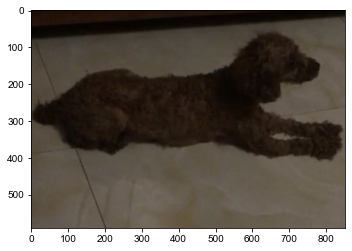

In [95]:
img = cv2.imread('images/dog.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

Text(0.5, 0, 'Pixel Values')

(0.0, 256.0)

Text(0.5, 0, 'Channels')

Text(0.5, 0, 'Counts')

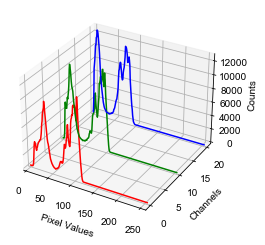

In [191]:
# 多通道直方图
hist_r = cv2.calcHist([img], [0], None, [256], [0, 256]) #img, channels, mask, histSize, ranges[, hist[, accumulate]])
hist_g = cv2.calcHist([img], [1], None, [256], [0, 256])
hist_b = cv2.calcHist([img], [2], None, [256], [0, 256])

ax=plt.axes(projection='3d')
for c, y, channel_hist in zip(['r', 'g', 'b'], [0, 10, 20], [hist_r, hist_g, hist_b]):
    ax.plot3D(range(256), channel_hist, zs=y, zdir='y',color=c)

ax.set_xlabel('Pixel Values')
ax.set_xlim([0, 256])
ax.set_ylabel('Channels')
ax.set_zlabel('Counts')
plt.show()

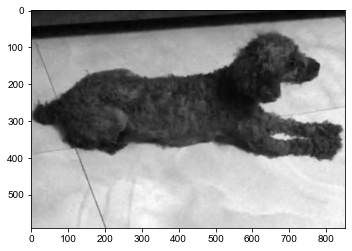

In [96]:
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(img, cmap='gray')

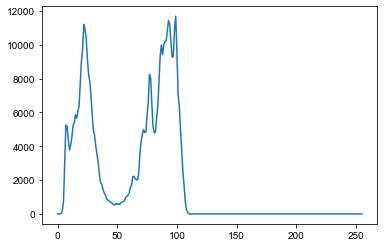

In [109]:
# 灰度直方图
# 用线图可视化统计结果
img_hist = np.zeros(256) #0-255共256个值
h,w = img.shape
for i in range(h):
    for j in range(w):
        img_hist[img[i][j]]+=1      
plt.plot(img_hist)

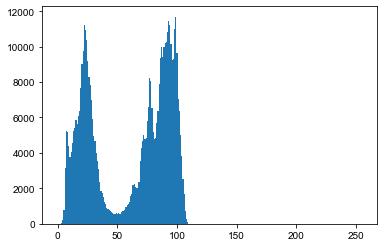

In [93]:
# 用hist图
plt.hist(img.reshape(-1), bins=256, range=[0,255]);

#### Reverse

(-12.75, 267.75, -12.75, 267.75)

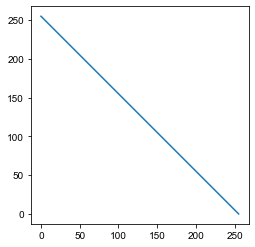

In [94]:
# 反色变换
def reverse(img):
    img = 255 - img #uint8格式用255减，0-1 float格式用1减
    return img

x = np.linspace(0,255,256)
plt.plot(x, reverse(x))
plt.axis('square')

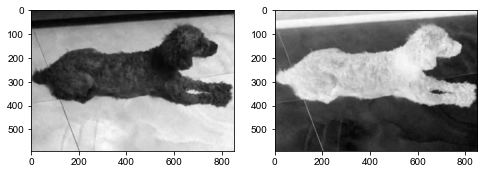

In [95]:
img_reverse = reverse(img)
f, (ax1,ax2) = plt.subplots(1,2, figsize=(8,3))
ax1.imshow(img, cmap='gray')
ax2.imshow(img_reverse, cmap='gray')

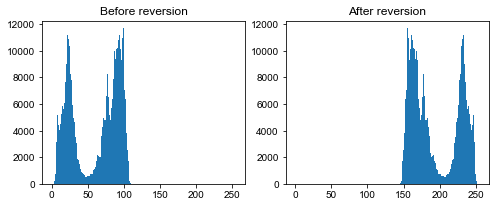

In [97]:
f, (ax1,ax2) = plt.subplots(1,2, figsize=(8,3))
ax1.hist(img.reshape(-1), bins=256, range=[0,255])
ax1.set_title('Before reversion');
ax2.hist(img_reverse.reshape(-1), bins=256, range=[0,255])
ax2.set_title('After reversion');

#### Contrast

(-12.75, 267.75, -12.75, 267.75)

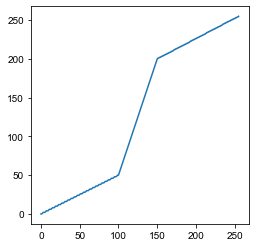

In [100]:
def enhance_contrast(img, x1=100, x2=150, y1=50, y2=200):
    p1=[y1/x1 * x for x in range(x1)] #灰度压缩
    p2=[(y2-y1)/(x2-x1) * x + y1-(y2-y1)*x1/(x2-x1) for x in range(x1, x2)]  #灰度拉伸
    p3=[(255-y2)/(255-x2) * x + y2-(255-y2)*x2/(255-x2) for x in range(x2, 256)] #灰度压缩
    table = p1+p2+p3
    table = np.round(np.array(table)).astype(np.uint8)
    img = cv2.LUT(img, table) #查表函数，把img每个像素索引contrast表 
    return img, table

table = enhance_contrast(img)[1]
plt.plot(table)
plt.axis('square')

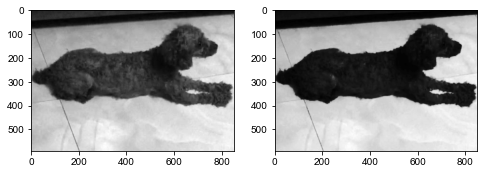

In [101]:
#由于图片大部分值都只在0-100之间，对应调整
img_contrast = enhance_contrast(img, x1=40, x2=60, y1=20, y2=80)[0] 
f, (ax1,ax2) = plt.subplots(1,2, figsize=(8,3))
ax1.imshow(img, cmap='gray')
ax2.imshow(img_contrast, cmap='gray')

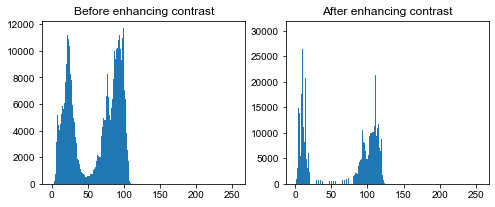

In [102]:
f, (ax1,ax2) = plt.subplots(1,2, figsize=(8,3))
ax1.hist(img.reshape(-1), bins=256, range=[0,255])
ax1.set_title('Before enhancing contrast');
ax2.hist(img_contrast.reshape(-1), bins=256, range=[0,255])
ax2.set_title('After enhancing contrast');

(-12.75, 267.75, -12.75, 267.75)

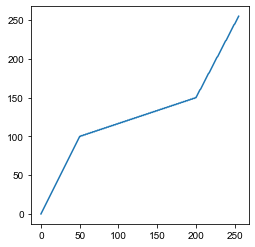

In [103]:
def compress_contrast(img, x1=50, x2=200, y1=100, y2=150):
    p1=[y1/x1 * x for x in range(x1)] #灰度拉伸
    p2=[(y2-y1)/(x2-x1) * x + y1-(y2-y1)*x1/(x2-x1) for x in range(x1, x2)] #灰度压缩
    p3=[(255-y2)/(255-x2) * x + y2-(255-y2)*x2/(255-x2) for x in range(x2, 256)] #灰度拉伸
    table = p1+p2+p3
    table = np.round(np.array(table)).astype(np.uint8)
    img = cv2.LUT(img, table) 
    return img, table

table = compress_contrast(img)[1]
plt.plot(table)
plt.axis('square')

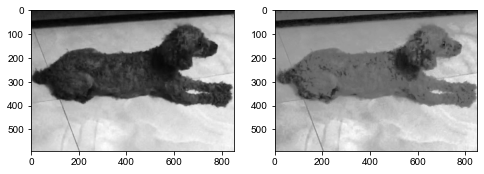

In [105]:
#由于图片大部分值都只在0-100之间，对应调整
img_contrast = compress_contrast(img, x1=20, x2=80, y1=40, y2=60)[0]
f, (ax1,ax2) = plt.subplots(1,2, figsize=(8,3))
ax1.imshow(img, cmap='gray')
ax2.imshow(img_contrast, cmap='gray')

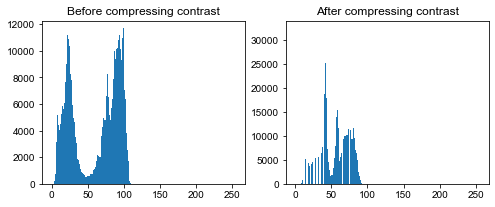

In [106]:
f, (ax1,ax2) = plt.subplots(1,2, figsize=(8,3))
ax1.hist(img.reshape(-1), bins=256, range=[0,255])
ax1.set_title('Before compressing contrast');
ax2.hist(img_contrast.reshape(-1), bins=256, range=[0,255])
ax2.set_title('After compressing contrast');

#### Gamma Correction
<img src='images/luminance.png' style="width:20%;height:20%"> <img src='images/gamma.png' style="width:25%;height:25%">

In [73]:
# Gamma变换，小于1的值让暗部细节大量提升，同时亮部细节少量提升
def gamma_correction(img, gamma=0.5):
    # 关系函数的像素值归一化到0-1，求出新的像素值再还原255
    gamma_table = [np.power(x/255.0, gamma)*255.0 for x in range(256)] 
    gamma_table = np.round(np.array(gamma_table)).astype(np.uint8) #确保格式  
    img = cv2.LUT(img, gamma_table) 
    return img

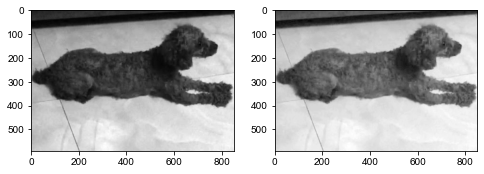

In [74]:
img_gamma = gamma_correction(img) 
f, (ax1,ax2) = plt.subplots(1,2, figsize=(8,3))
ax1.imshow(img, cmap='gray')
ax2.imshow(img_gamma, cmap='gray')

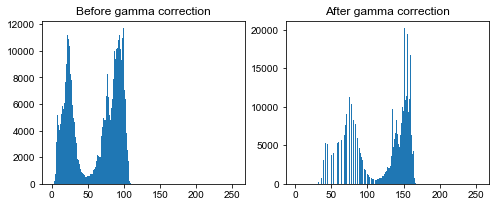

In [107]:
f, (ax1,ax2) = plt.subplots(1,2, figsize=(8,3))
ax1.hist(img.reshape(-1), bins=256, range=[0,255])
ax1.set_title('Before gamma correction');
ax2.hist(img_gamma.reshape(-1), bins=256, range=[0,255])
ax2.set_title('After gamma correction');

#### Histogram Equalization
直方图均衡化就是通过normalize count比例，调整原像素的分布，使原来集中在深色区域的灰度图能更均衡地展示整体颜色细节，变亮的同时保持颜色比例和谐

In [108]:
# 直方图均衡化
def equalize_hist(img, img_hist):
    # 方法一：原理
    trans = img_hist/(h*w)*255 #0-255每个值所占总数a% 乘以255得到每个值对应的bins范围 [0,a%*255]
    for i in range(1,len(trans)):
        trans[i]+=trans[i-1] #假设0分布在bins[0,1%*255]，1分布要接在其后[1%*255,1%*255+2%*255]
    trans=trans.astype('uint8')
    img_eh = cv2.LUT(img, trans) 
    
    #方法二：调包
    img_eh = cv2.equalizeHist(img) #如果图片是RGB，可以分别对三个channel做均衡化img[...,c]再拼接
    return img_eh

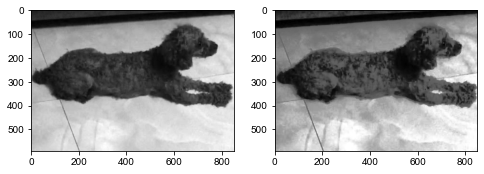

In [110]:
img_equal = equalize_hist(img, img_hist) 
f, (ax1,ax2) = plt.subplots(1,2, figsize=(8,3))
ax1.imshow(img, cmap='gray')
ax2.imshow(img_equal, cmap='gray')

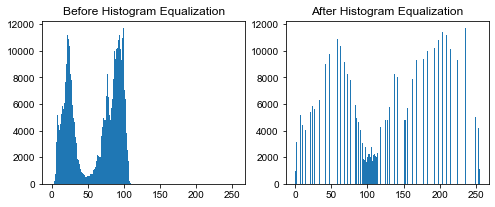

In [111]:
f, (ax1,ax2) = plt.subplots(1,2, figsize=(8,3))
ax1.hist(img.reshape(-1), bins=256, range=[0,255])
ax1.set_title('Before Histogram Equalization');
ax2.hist(img_equal.reshape(-1), bins=256, range=[0,255])
ax2.set_title('After Histogram Equalization');